# SOC LEAFs Grassland Supporting calculations
This notebook documents the generation of grassland base data needed to run RothC model and serves as a complement to [SOC_LEAFs_Baseline](../documentation/SOC_LEAFs_Baseline.ipynb) notebook. Soil & Weather data has already been generated to run crop commodities and thus it's not explained here.

## Step 1 - Data Preparation
### 1) Residues
As land use has already been determined, the next step is to estimate annual and monthly residue production. Annual residue production is per climate zone is obtained from Table 6.4 of the [2006 IPCC](https://www.ipcc-nggip.iges.or.jp/public/2006gl/pdf/4_Volume4/V4_06_Ch6_Grassland.pdf). Due to the high error range (75%), a random value is generated per UHTH pixel during each run using a normal distribution. 

Residues production values have been summarized in [grassland_residues_IPCC](../data/grasslands/grassland_residues_IPCC.xlsx) excel spreadsheet, which have been mapped into FAO GAEZ climate zones.

As there is a single grassland land use map, residue production needs to be generated crossing land use, climate zones, and table residue data. This is done as follows, and is done on each iteration of RothC:

In [2]:
# modules
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import rioxarray
import rasterio
import importlib
from rasterio.enums import Resampling
import sbtn_leaf.map_plotting as mp
import polars as pl
import geopandas as gpd
import sbtn_leaf.cropcalcs as cropcalcs
import sbtn_leaf.map_plotting as mp
import sbtn_leaf.map_calculations as mc
import requests
from pathlib import Path
from typing import List, Optional, Union

Could not determine dtype for column 1, falling back to string


In [ ]:
# data
grassland_residue_raster = cropcalcs.generate_grassland_residue_map()

Examining...

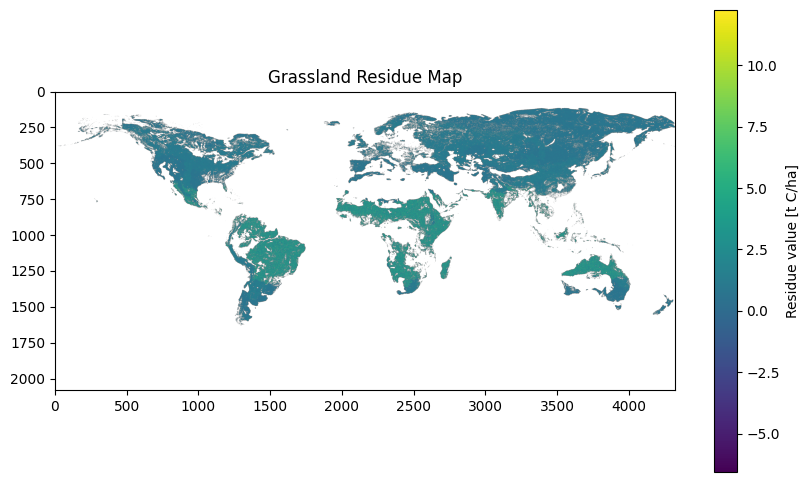

In [ ]:
plt.figure(figsize=(10, 6))
img = plt.imshow(grassland_residue_raster.squeeze(), cmap='viridis')
plt.colorbar(img, label='Residue value [t C/ha]')
plt.title('Grassland Residue Map')
plt.show()


### 2 - Shitty calculations
So now we have to calculate how much shit goes into the grass, the most fun part of all SOC calculations...

To calculate dung depositions into each pixel, the following equation is applied:
$$ Dung_{p} = \sum_a {LSU_{p,a}\cdot CD_{a,r}} $$

Where:
- $\textstyle Dung_{p}$ represents the annual carbon input from dung deposition in pixel $\textstyle p$
- $\textstyle LSU_{p,a}$ is the 10-year average amount of livestock units of animal a (cattle, sheep, and goats)
- $\textstyle CD_{a,r}$ is the carbon input from dung depositions from animal $\textstyle a$ in region $\textstyle r$

LSU is obtained from [Global Pasture Watch](https://landcarbonlab.org/about-global-pasture-watch/), while $\textstyle CD_{a,r}$ is calculated from [IPCC 2019](https://www.ipcc-nggip.iges.or.jp/public/2019rf/pdf/4_Volume4/19R_V4_Ch10_Livestock.pdf) and [FAO's Farmer’s Compost Handbook—Experiences in Latin America](https://openknowledge.fao.org/server/api/core/bitstreams/0658b4e0-53e3-4ed7-89d0-ff351bec1dff/content) C:N ratios.

#### 2.1 Average Livestock units
Two sets of values are calculated: a) average livestock density (number of heads per hectare) and b) prediction uncertainty. A 10-year average between 2011 and 2021 is calculated, as 2016 is SOC baseline year and represents the midpoint.

##### Data download
An inventory with needed layers is available upon request from Global Forest Watch. Rasters are on 1km pixel resolution.

Loading the excel and downloading the needed data...

In [60]:
lsu_files = pl.read_excel("../data/grasslands/GPW_ Global Pasture Watch ARCO layers_livestock_resubmission.xlsx")

Creating files list per animal

In [ ]:
lsu_cattle_s3rasters = lsu_files.filter((pl.col("Livestock animal") == "Cattle") & (pl.col("Year").is_between(2011, 2021)) & (pl.col("Type") == "Livestock density") & (pl.col("Model output").is_in(["Mean prediction", "Prediction uncertainty"])))

lsu_sheep_s3rasters = lsu_files.filter((pl.col("Livestock animal") == "Sheep") & (pl.col("Year").is_between(2011, 2021)) & (pl.col("Type") == "Livestock density") & (pl.col("Model output").is_in(["Mean prediction", "Prediction uncertainty"])))

lsu_goat_s3rasters = lsu_files.filter((pl.col("Livestock animal") == "Goat") & (pl.col("Year").is_between(2011, 2021)) & (pl.col("Type") == "Livestock density") & (pl.col("Model output").is_in(["Mean prediction", "Prediction uncertainty"])))

Downloading files

In [ ]:
download_folder = "../data/grasslands/livestock/cattle/"
for row in lsu_cattle_s3rasters.iter_rows(named=True):
    # Getting needed information from each row
    url = row["URL"]
    animal = "cattle"
    year = row["Year"]

    if row["Model output"] == "Mean prediction":
        output_type = "mean"
    else:
        if "p.975" in url:
            output_type = "uncert_975"
        else:
            output_type = "uncert_025"

    # Constructing file name
    file_name = f"{animal}_{year}_{output_type}.tif"
    output_path = f"{download_folder}{file_name}"

    print(f"Downloading url {url} into {output_path}")
    # Download file
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

In [ ]:
download_folder = "../data/grasslands/livestock/sheep/"
for row in lsu_sheep_s3rasters.iter_rows(named=True):
    # Getting needed information from each row
    url = row["URL"]
    animal = "sheep"
    year = row["Year"]

    if row["Model output"] == "Mean prediction":
        output_type = "mean"
    else:
        if "p.975" in url:
            output_type = "uncert_975"
        else:
            output_type = "uncert_025"

    # Constructing file name
    file_name = f"{animal}_{year}_{output_type}.tif"
    output_path = f"{download_folder}{file_name}"

    print(f"Downloading url {url} into {output_path}")
    # Download file
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

In [ ]:
download_folder = "../data/grasslands/livestock/goat/"
for row in lsu_goat_s3rasters.iter_rows(named=True):
    # Getting needed information from each row
    url = row["URL"]
    animal = "goat"
    year = row["Year"]

    if row["Model output"] == "Mean prediction":
        output_type = "mean"
    else:
        if "p.975" in url:
            output_type = "uncert_975"
        else:
            output_type = "uncert_025"

    # Constructing file name
    file_name = f"{animal}_{year}_{output_type}.tif"
    output_path = f"{download_folder}{file_name}"

    print(f"Downloading url {url} into {output_path}")
    # Download file
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

print("All done...")      

All done...


Now creating the 10-year average, including upper and lower bound. This is simply done by averaging each year data. Future development could include calculating per pixel average using monte carlo simulations to estimate LSU per pixel

Getting all the files in needed groups

In [1]:
# Function to scan folder and select files
def identify_files_with_string(folder: Union[str, Path], string_ind: str, extension: Optional[List[str]] = None):
    folder_path = Path(folder)
    files = folder_path.iterdir()

    if extension:
        norm_ext = {e if e.startswith(".") else f".{e}" for e in extension}
        matches = [f for f in files if f.is_file() and string_ind in f.name and f.suffix in norm_ext]
    else:
        matches = [f for f in files if f.is_file() and string_ind in f.name]

    return matches

NameError: name 'Union' is not defined

Running the function...

In [5]:
cattle_mean_files = identify_files_with_string("../data/grasslands/livestock/cattle/", "mean", [".tif"])
cattle_uncert975_files = identify_files_with_string("../data/grasslands/livestock/cattle/", "uncert_975", [".tif"])
cattle_uncert025_files = identify_files_with_string("../data/grasslands/livestock/cattle/", "uncert_025", [".tif"])

goat_mean_files = identify_files_with_string("../data/grasslands/livestock/goat/", "mean", [".tif"])
goat_uncert975_files = identify_files_with_string("../data/grasslands/livestock/goat/", "uncert_975", [".tif"])
goat_uncert025_files = identify_files_with_string("../data/grasslands/livestock/goat/", "uncert_025", [".tif"])

sheep_mean_files = identify_files_with_string("../data/grasslands/livestock/sheep/", "mean", [".tif"])
sheep_uncert975_files = identify_files_with_string("../data/grasslands/livestock/sheep/", "uncert_975", [".tif"])
sheep_uncert025_files = identify_files_with_string("../data/grasslands/livestock/sheep/", "uncert_025", [".tif"])

Now calculating the averages

In [17]:
mc.calculate_average_from_raster_timeseries(cattle_mean_files, "../data/grasslands/livestock/cattle/cattle_lsu_10yr_mean.tif")

Calculating raster series average::   0%|          | 0/11 [00:00<?, ?file/s]

MemoryError: Unable to allocate 1.96 GiB for an array with shape (14005, 37504) and data type float32

In [14]:
mp.inspect_raster( "../data/grasslands/livestock/cattle/cattle_lsu_10yr_mean.tif")

File: ../data/grasslands/livestock/cattle/cattle_lsu_10yr_mean.tif
Driver: GTiff
Width, Height: 37504, 14005
Number of Bands: 1
CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Bounds: BoundingBox(left=-17677000.0, bottom=-6150000.0, right=19827000.0, top=7855000.0)
Pixel Size: (1000.0, 1000.0)
No-data Value: nan

--- Raster Metadata ---
AREA_OR_POINT: Area

--- Band Information ---

Band 1:
  Data Type: float32
  Min Value: 0.0
  Max Value: 12010.63671875
  Mean Value: 402.7218017578125
  Standard Deviation: 798.1784057617188


In [15]:
mp.plot_raster_on_world_extremes_cutoff( "../data/grasslands/livestock/cattle/cattle_lsu_10yr_mean.tif", "Test")

Raster has 41,175 different values. Min: 0.00. Max: 3,743.09
Not using quantiles
All positives route


MemoryError: Unable to allocate 15.7 GiB for an array with shape (14005, 37504, 4) and data type float64

MemoryError: Unable to allocate 3.91 GiB for an array with shape (14005, 37504) and data type float64

<Figure size 1400x800 with 2 Axes>

In [10]:
importlib.reload(mc)

<module 'sbtn_leaf.map_calculations' from 'C:\\Users\\loyola\\OneDrive - World Wildlife Fund, Inc\\Documents\\203. Python projects\\SBTN_Test\\src\\sbtn_leaf\\map_calculations.py'>

# 2 - Run RothC
All other information has already been generated for annual crops. 

Roth C for forest can be run as

In [2]:
import sbtn_leaf.RothC_Raster as rothc

In [4]:
import importlib

In [22]:
importlib.reload(rothc)
importlib.reload(cropcalcs)

Could not determine dtype for column 1, falling back to string
Could not determine dtype for column 8, falling back to string
Could not determine dtype for column 9, falling back to string


<module 'sbtn_leaf.cropcalcs' from 'C:\\Users\\loyola\\OneDrive - World Wildlife Fund, Inc\\Documents\\203. Python projects\\SBTN_Test\\src\\sbtn_leaf\\cropcalcs.py'>

In [10]:
# Extra fp needed
lu_forest_fp = "../data/land_use/lu_Needleleaf_Evergreen_Cold_temperate_moist.tif"
age_fp = "../data/forest/age/Needleleaf_Evergreen_Boreal_moist_age.tif"

In [24]:
forest_soc_test = rothc.run_RothC_forest(
    lu_fp=lu_forest_fp,
    forest_type="NEEV",
    weather_type="Cold temperate moist",
    n_years=5,
    save_folder="../LEAFs",
    age_fp=age_fp,
    evap_fp="../data/soil_weather/uhth_pet_locationonly.tif",
    data_description="Forest Test"
)

Loading environmental data...
Loading forest data...
Running RothC...


C:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\src\sbtn_leaf\RothC_Core.py:69: RuntimeWarning: overflow encountered in exp
  rmf = 47.91 / (np.exp(106.06 / (tmp + 18.27)) + 1.0)
RothC months: 100%|██████████| 60/60 [02:26<00:00,  2.44s/it]


Checking results...

In [25]:
forest_soc_test_fp = '../LEAFs/NEEV_None_5y_SOC.tif'

In [26]:
mp.inspect_raster(forest_soc_test_fp)

File: ../LEAFs/NEEV_None_5y_SOC.tif
Driver: GTiff
Width, Height: 4320, 2083
Number of Bands: 6
CRS: EPSG:4326
Bounds: BoundingBox(left=-179.99999999999997, bottom=-89.99999999999994, right=179.99999999999991, top=83.58333333333331)
Pixel Size: (0.0833333333333333, 0.0833333333333333)
No-data Value: nan

--- Raster Metadata ---
description: Forest Test
long_name: Soil Organic Carbon
model: RothC rasterized vectorized
units: t C/ha
AREA_OR_POINT: Area

--- Band Information ---

Band 1:
  Data Type: float32
  Min Value: 6.81576681137085
  Max Value: 164.99652099609375
  Mean Value: 56.361671447753906
  Standard Deviation: 21.169614791870117

Band 2:
  Data Type: float32
  Min Value: 9.164597511291504
  Max Value: 162.54275512695312
  Mean Value: 57.410484313964844
  Standard Deviation: 20.584999084472656

Band 3:
  Data Type: float32
  Min Value: 11.680132865905762
  Max Value: 160.43746948242188
  Mean Value: 59.296138763427734
  Standard Deviation: 20.23917007446289

Band 4:
  Data Type

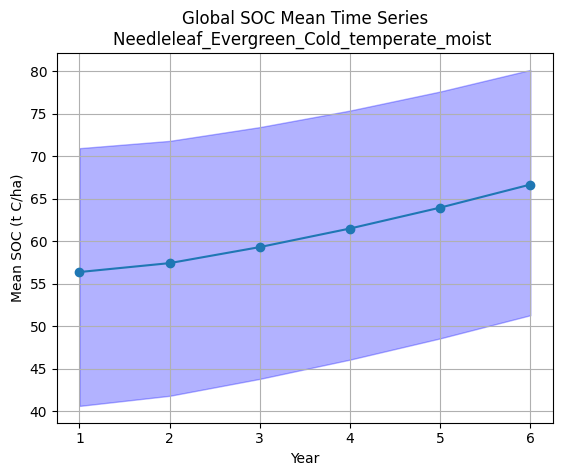

In [ ]:
mp.plot_multiband_raster_timesires(forest_soc_test_fp, "Global SOC Mean Time Series\nNeedleleaf_Evergreen_Cold_temperate_moist", show_iq=True)

Raster has 193,878 different values. Min: 32.94. Max: 109.09
Using quantiles
All positives route


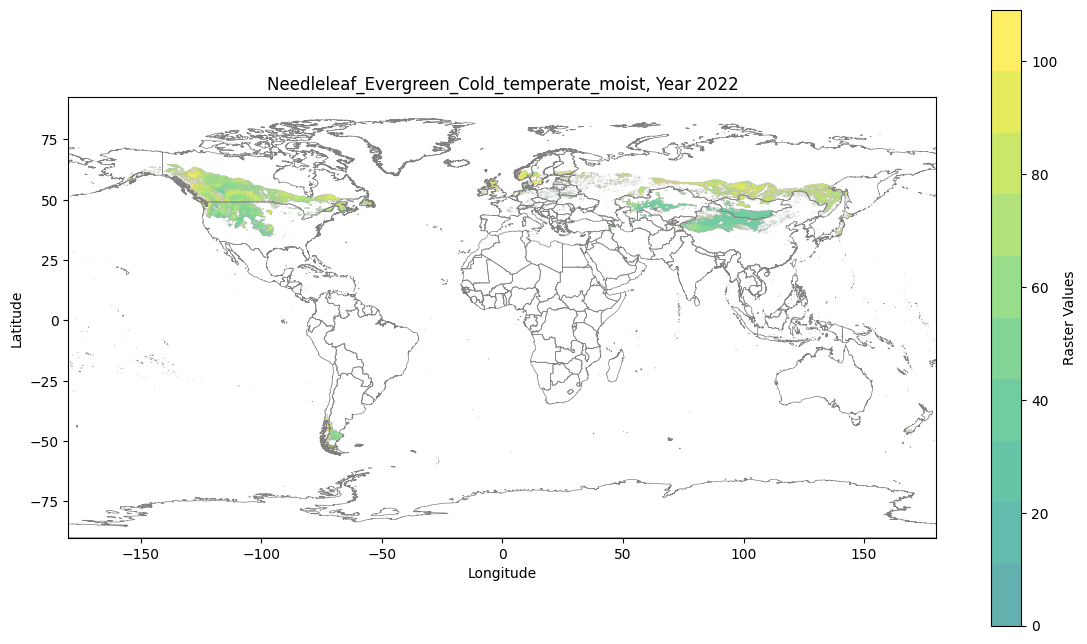

In [28]:
mp.plot_raster_on_world_extremes_cutoff(forest_soc_test_fp, "Needleleaf_Evergreen_Cold_temperate_moist, Year 2022", raster_band=6, alpha=1, quantiles=10)

In [33]:
pct_change = rothc.calcuate_annual_perc_changes(forest_soc_test_fp)

Raster has 190,136 different values. Min: 0.23. Max: 71.81
Using quantiles
All positives route


(<Figure size 1400x800 with 2 Axes>,
 <Axes: title={'center': 'SOC Percentage change by year 2022 for\nNeedleleaf_Evergreen_Cold_temperate_moist'}, xlabel='Longitude', ylabel='Latitude'>)

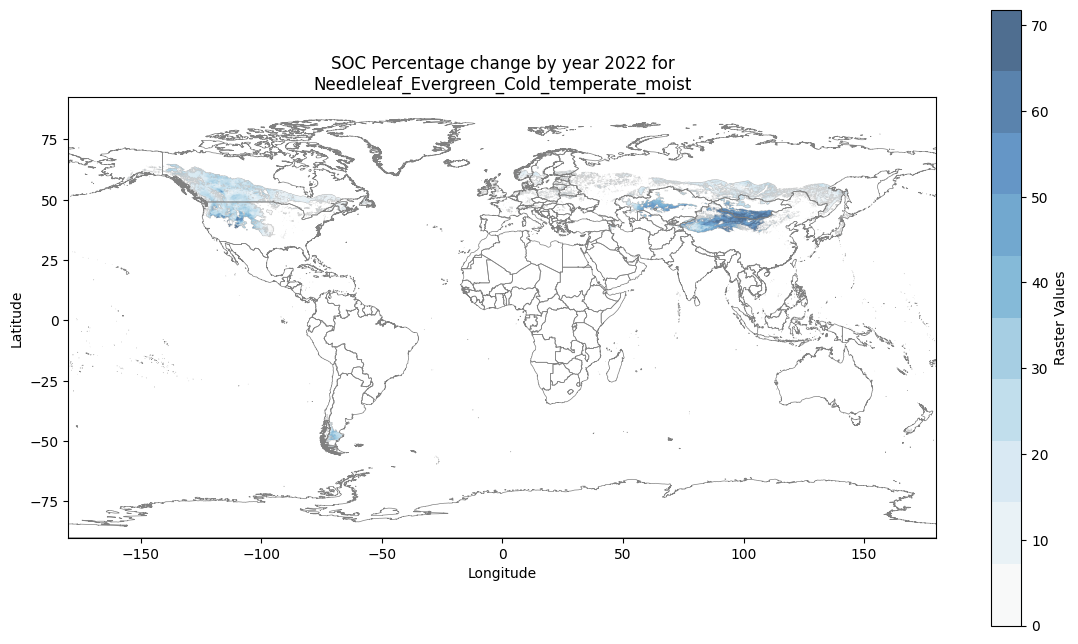

In [44]:
mp.plot_da_on_world_extremes_cutoff(pct_change, "SOC Percentage change by year 2022 for\nNeedleleaf_Evergreen_Cold_temperate_moist", band=5, cmap="RdBu", quantiles=10) # type: ignore